# Simple speech recognition

Audio 데이터를 다뤄서 학습하는 방법을 배워보도록 합시다.
머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.
* tensorflow 2.1 버전에 최적화되어있습니다.

## Project 설명
### Task
* 1초 길이의 오디오 음성데이터를 이용해 단어를 분류하는 것이 목표입니다.
* 주어진 데이터를 이용해 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
* This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.

### Baseline
* 기본적으로 사용하는 Convulution layers를 구성해 사용해보자.
    * ex) Conv - Conv - pooling - FC layers
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
* Training
    * tf.data.dataset과 model.fit()을 사용
* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### Setting tensorflow version

In [0]:
!pip install tensorflow-gpu==2.1

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy

tf.__version__

'2.2.0'

## Import modules

### Import colab modules for Google Colab (if necessary)

In [0]:
use_colab = True
assert use_colab in [True, False]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
if use_colab:
    DATASET_PATH='./gdrive/My Drive/datasets'
else:
    DATASET_PATH='./datasets'

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

    import urllib.request
    u = urllib.request.urlopen(url='http://bigfile.mail.naver.com/bigfileupload/download?fid=8XYZaAIq1NKmKqujKCYXKxKrFqKjKogZKAg9Kx2waxUmKqKjKxElKotmFxvla3e4KzUrK6KXK4UmFxiCMoU9KrudpoivaxpCFqblpAEZMm==')
    data = u.read()
    u.close()
    
else:
    print('Data has already been downloaded and extracted.')

### Checking dataset

In [0]:
speech_data = np.load("/content/drive/My Drive/datasets/speech_wav_8000.npz")

In [0]:
test_wav = speech_data["wav_vals"][0]

In [6]:
test_wav.shape

(8000,)

### Wave to spectrogram
* STFT를 이용해서 wave 형태의 데이터를 spectrogram으로 만들어준다.

In [0]:
def wav2spec(wav, fft_size=258):
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [0]:
spec = wav2spec(test_wav)

In [9]:
spec.shape

(130, 126)

In [10]:
spec.shape[0]

130

* Spectrogram으로 변환한 데이터를 plot 해본다.

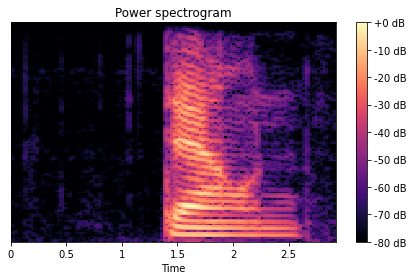

In [11]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

* 전체 데이터셋의 wave 데이터를 spectrogram으로 변환한다.

In [0]:
temp = []
# 전체 wave 데이터를 spectogram으로 변형 작업
for v in speech_data["wav_vals"]:
    wav = v
    stft = wav2spec(wav)
    temp.append(stft)
data_wav = np.array(temp)

In [13]:
data_wav.shape

(50620, 130, 126)

### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정한다.

In [14]:
train_wav, test_wav, train_label, test_label = train_test_split(data_wav, speech_data["label_vals"], 
                                                                test_size=0.1, 
                                                                random_state = 1993, 
                                                                shuffle=True)

train_wav = train_wav.reshape(-1, 130, 126, 1)
test_wav = test_wav.reshape(-1, 130, 126, 1)

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)

(45558, 130, 126, 1)
(5062, 130, 126, 1)
(45558, 1)
(5062, 1)


### Target_list 설정

In [0]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [0]:
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

In [0]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

### Hyper-parameter setting

In [0]:
batch_size = #
max_epochs = #

# the save point
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/spectrogram/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'spectrogram/exp1'

## tf.data.dataset Setting

In [0]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [0]:
# for train
train_dataset = #
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = #
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

## Model 구현


In [0]:
inputs = layers.Input(shape=(130, 126, 1))

x = #

model = tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
optimizer=#
model.compile(loss=#,
             optimizer=optimizer,
             metrics=['accuracy'])

In [0]:
# without training, just inference a model in eager execution:
predictions = model(train_wav[0:1], training=False)
print("Predictions: ", predictions.numpy())

### 구성된 모델 확인

In [0]:
model.summary()

In [0]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

## 모델 학습

In [0]:
# using `tf.data.Dataset`
history = model.fit(#trian_data,
                    epochs=#,
                    steps_per_epoch=#,
                    validation_data=#,
                    validation_steps=#
                    )

In [0]:
checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation
* Test dataset을 이용해서 모델의 성능을 평가합니다.

In [0]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
results = model.evaluate(test_dataset)

In [0]:
# 내가 녹음한데이터를 써보려면 input 형태를 맞춰주면 (1초, 타입 등등)
# result = model.evaluate(rec_data) 
# 를하면 벡터형태로 12개가 return 된다.